Assignment Day 25 - Regularized Regression in Python <br>
Chintia Hildayanti <br>
Data Science Batch 26

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data
boston = pd.read_csv('/content/drive/MyDrive/boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### About The Dataset

* Criminal rate (crim) <br>
* Residential land zoned proportion (zn)
* Non-retail business acres proportion (indus) <br>
* Is bounds with river (chas) <br>
* Nitrogen oxides concentration (nox) <br>
* Number rooms average (rm) <br>
* Owner age proportion (age) <br>
* Weighted distance to cities (dis) <br>
* Accessibility index (rad) <br>
* Tax rate (tax) <br>
* Pupil-teacher ratio (ptratio) <br>
* Black proportion (black) <br>
* Percent lower status (lstat) <br>


## Predict the price of house in boston (medv)

## 1. Split The Data (Train-Validation-Test)

In [ ]:
from sklearn.model_selection import train_test_split

feature = boston.drop(columns='medv')
target = boston[['medv']]

# First splitting: pretrain and test
feature_boston_pretrain, feature_boston_test, target_boston_pretrain, target_boston_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_boston_train, feature_boston_validation, target_boston_train, target_boston_validation = train_test_split(feature_boston_pretrain, target_boston_pretrain, test_size=0.20, random_state=42)

## 2. Multicollinearity Check (Feature Selection)

In [ ]:
# menghitung vif_score

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

x = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(x.values, i) for i in range(x.shape[1])], index = x.columns).reset_index()

vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature != 'const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


terdapat 4 fitur yang memiliki vif_score > 4 yaitu nox, dis, rad, tax

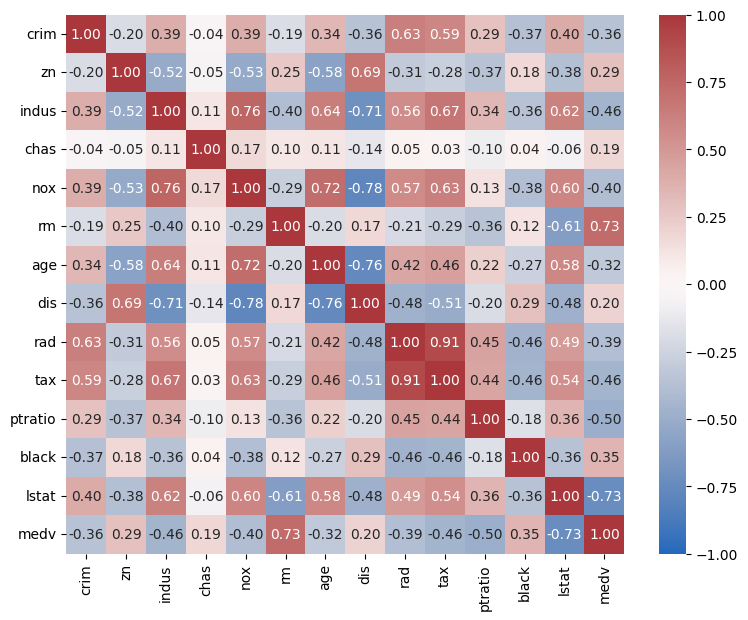

In [ ]:
boston_train = pd.concat([feature_boston_train, target_boston_train], axis=1)
boston_corr = boston_train.corr()

plt.figure(figsize=(9,7))
sns.heatmap(boston_corr, annot=True, fmt = '.2f', cmap = 'vlag', vmin= -1, vmax = 1)
plt.show()

menurut vif_score ada 4 feature yang bernilai diatas 4, dan berdasarkan heatmap correlation ada 2 pasangan yang memiliki korelasi >0.70 (saya pakai batas nilai ini untuk menghapus 3 fitur yang memiliki vif_score diatas 4) pasangan nox & dis memiliki korelasi -0.78 dan pasangan tax & rad memiliki korelasi yang paling tinggi yaitu 0.91, jika melihat target variabel (medv) fitur tax memiliki korelasi paling kuat diantara yang lain yaitu -0.46, jadi tax dipertahankan nox, dis dan rad di drop.

In [ ]:
# menghapus fitur nox, dis dan rad dari seluruh dataset
feature_boston_train = feature_boston_train.drop(columns = ['nox','dis','rad'])
feature_boston_validation = feature_boston_validation.drop(columns = ['nox','dis','rad'])
feature_boston_test = feature_boston_test.drop(columns = ['nox','dis','rad'])

feature_boston_train.columns

Index(['crim', 'zn', 'indus', 'chas', 'rm', 'age', 'tax', 'ptratio', 'black',
       'lstat'],
      dtype='object')

In [ ]:
# mengecek kembali vif_score

x = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(x.values, i) for i in range(x.shape[1])], index = x.columns).reset_index()

vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature != 'const']
vif_df

,feature,vif_score
1,crim,1.596586
2,zn,1.832693
3,indus,2.970810
4,chas,1.078919
5,rm,1.891979
6,age,2.491050
7,tax,2.827854
8,ptratio,1.480472
9,black,1.346511
10,lstat,2.935815


# 3. Model Training

## Ridge Regression

In [ ]:
# Model Fitting

from sklearn.linear_model import Ridge

feature_boston_np_train = feature_boston_train.to_numpy()
target_boston_np_train = target_boston_train.to_numpy()
target_boston_np_train = target_boston_np_train.reshape(len(target_boston_train))

# lambda = alpha
# alpha = [0.01, 0.1, 1, 10]

ridge_reg_001 = Ridge(alpha=0.01, random_state=42)
ridge_reg_01 = Ridge(alpha=0.1, random_state=42)
ridge_reg_1 = Ridge(alpha=1, random_state=42)
ridge_reg_10 = Ridge(alpha=10, random_state=42)

ridge_reg_001.fit(feature_boston_np_train, target_boston_np_train)
ridge_reg_01.fit(feature_boston_np_train, target_boston_np_train)
ridge_reg_1.fit(feature_boston_np_train, target_boston_np_train)
ridge_reg_10.fit(feature_boston_np_train, target_boston_np_train)

Ridge(alpha=10, random_state=42)

In [ ]:
# Model Validation

from sklearn.metrics import mean_squared_error

feature_boston_np_validation = feature_boston_validation.to_numpy()
target_boston_np_validation = target_boston_validation.to_numpy()
target_boston_np_validation = target_boston_np_validation.reshape(len(target_boston_np_validation))

alpha = [0.01, 0.1, 1, 10]
models = [ridge_reg_001, ridge_reg_01, ridge_reg_1, ridge_reg_10]

for models, alpha in zip(models, alpha):
    target_boston_predict_validation = models.predict(feature_boston_np_validation)
    rmse = np.sqrt(mean_squared_error(target_boston_np_validation,target_boston_predict_validation))
    print(f'RMSE validation of Ridge Regression with lambda = {alpha} is {rmse}')

RMSE validation of Ridge Regression with lambda = 0.01 is 5.100886202642037
RMSE validation of Ridge Regression with lambda = 0.1 is 5.100288438419682
RMSE validation of Ridge Regression with lambda = 1 is 5.094521787042945
RMSE validation of Ridge Regression with lambda = 10 is 5.05166207510316


Lambda 10 memiliki RMSE paling kecil yaitu 5.051, jadi lambda 10 adalah yang terbaik untuk Ridge Regression

In [ ]:
# Ridge Model Coefficient

best_ridge = ridge_reg_10

ridge_coefficient_df = pd.DataFrame({
                    'feature': ['intercept'] + feature_boston_train.columns.to_list(),
                    'coefficient': [best_ridge.intercept_] + list(best_ridge.coef_)
})

ridge_coefficient_df

,feature,coefficient
0,intercept,7.068423
1,crim,-0.052216
2,zn,-0.007855
3,indus,0.034094
4,chas,2.061822
5,rm,5.041802
6,age,0.020313
7,tax,-0.000312
8,ptratio,-0.845843
9,black,0.012919


### Interpretasi <br>
rm (jumlah rata-rata kamar per hunian)<br>
Koefisien == 5.041802<br>
<br>
Fitur ini memiliki koefisien positif yang paling besar. setiap Peningkatan satu unit dalam fitur rm dikaitkan dengan peningkatan medv sebesar 5.041802, asumsi semua variabel lain konstan. fitur rm memiliki kontribusi paling besar terhadap target variable (medv)

## LASSO Regression

In [ ]:
# Model Fitting

from sklearn.linear_model import Lasso

# lambda = alpha
# alpha = [0.01, 0.1, 1, 10]

lasso_reg_001 = Lasso(alpha=0.01, random_state=42)
lasso_reg_01 = Lasso(alpha=0.1, random_state=42)
lasso_reg_1 = Lasso(alpha=1, random_state=42)
lasso_reg_10 = Lasso(alpha=10, random_state=42)

lasso_reg_001.fit(feature_boston_np_train, target_boston_np_train)
lasso_reg_01.fit(feature_boston_np_train, target_boston_np_train)
lasso_reg_1.fit(feature_boston_np_train, target_boston_np_train)
lasso_reg_10.fit(feature_boston_np_train, target_boston_np_train)

Lasso(alpha=10, random_state=42)

In [ ]:
# Model Validation

from sklearn.metrics import mean_squared_error

alpha = [0.01, 0.1, 1, 10]
models = [lasso_reg_001, lasso_reg_01, lasso_reg_1, lasso_reg_10]

for models, alpha in zip(models, alpha):
    target_boston_predict_validation = models.predict(feature_boston_np_validation)
    rmse = np.sqrt(mean_squared_error(target_boston_np_validation,target_boston_predict_validation))
    print(f'RMSE validation of LASSO Regression with lambda = {alpha} is {rmse}')

RMSE validation of LASSO Regression with lambda = 0.01 is 5.097514590498467
RMSE validation of LASSO Regression with lambda = 0.1 is 5.08016984806439
RMSE validation of LASSO Regression with lambda = 1 is 4.988309999786157
RMSE validation of LASSO Regression with lambda = 10 is 5.426622694252769


Lambda 1 memiliki RMSE paling kecil yaitu 4.988, jadi lambda 1 adalah yang terbaik untuk Lasso Regression

In [ ]:
# Lasso Model Coefficient

best_lasso = lasso_reg_1

lasso_coefficient_df = pd.DataFrame({
                    'feature': ['intercept'] + feature_boston_train.columns.to_list(),
                    'coefficient': [best_lasso.intercept_] + list(best_lasso.coef_)
})

lasso_coefficient_df

,feature,coefficient
0,intercept,22.945673
1,crim,-0.034953
2,zn,0.001941
3,indus,-0.000000
4,chas,0.000000
5,rm,2.572882
6,age,0.041419
7,tax,-0.001003
8,ptratio,-0.757735
9,black,0.011371


## Interpretasi <br>

LASSO regression menganggap fitur indus dan chas tidak penting (koefisien = 0)<br>

Fitur rm memiliki koefisien positif yang paling besar (2.572). setiap Peningkatan satu unit dalam fitur rm dikaitkan dengan peningkatan medv sebesar 2.572882, asumsi semua variabel lain konstan. fitur rm memiliki kontribusi paling besar terhadap target variable (medv)

Saya memilih lasso regression karena memiliki nilai RMSE yang lebih kecil yaitu 4.988 dibanding ridge 5.051. <br>

dan juga karena saya tidak paham betul apakah target variabel dipengaruhi banyak atau sedikit faktor, saya memilih lasso regression untuk membantu saya memilih fitur yang penting dan tidak penting

# Model Evaluation

In [ ]:
# Training error

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

target_boston_predict_train = best_lasso.predict(feature_boston_np_train)

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(target_boston_np_train, target_boston_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(target_boston_np_train, target_boston_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(target_boston_np_train, target_boston_predict_train)))

RMSE for training data is 5.299257784164325
MAE for training data is 3.815568478973893
MAPE for training data is 0.18015928311790003


In [ ]:
# Test error

feature_boston_np_test = feature_boston_test.to_numpy()
target_boston_np_test = target_boston_test.to_numpy()
target_boston_np_test = target_boston_np_test.reshape(len(target_boston_np_test))
target_boston_predict_test = best_lasso.predict(feature_boston_np_test)

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(target_boston_np_test, target_boston_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(target_boston_np_test, target_boston_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(target_boston_np_test, target_boston_predict_test)))

RMSE for testing data is 5.315646725734099
MAE for testing data is 3.535684907677296
MAPE for testing data is 0.18439385451147544


dilihat dari hasil evaluasi, MAPE dari training data adalah 18,01% berarti model lasso dapat memprediksi dengan baik 81.99% data training <br>

MAPE dari testing data adalah 18,43% berarti model lasso dapat memprediksi dengan baik 81.57% data testing <br>

tidak ada perbedaan yang signifikan antara nilai training dan test, yang berarti model lasso regression ini tidak overfitting <br>